# Load Annotations

In [1]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
train_dir = "dataset/train"
valid_dir = "dataset/valid"
test_dir = "dataset/test"

In [3]:
train_file = glob.glob(f"{train_dir}/*.json")
train_file

['dataset/train\\_annotations.coco.json']

In [4]:
json.load(open(train_file[0])).keys()   # Remove .keys(), if you want to print the whole json file

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [5]:
valid_file = glob.glob(f"{valid_dir}/*.json")
test_file = glob.glob(f"{test_dir}/*.json")

In [6]:
train_annot = json.load(open(train_file[0]))
valid_annot = json.load(open(valid_file[0]))
test_annot = json.load(open(test_file[0]))

In [7]:
print(train_annot.keys())
print(valid_annot.keys())
print(test_annot.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


# Access images and segmentation data

In [8]:
len(train_annot["images"])

1502

In [9]:
idx = 1003

train_annot["images"][idx]

{'id': 1003,
 'license': 1,
 'file_name': '170_jpg.rf.243dbc079c83ebc2b6206b214abbdd1e.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-19T04:37:54+00:00'}

In [10]:
img_name = train_annot["images"][idx]["file_name"]

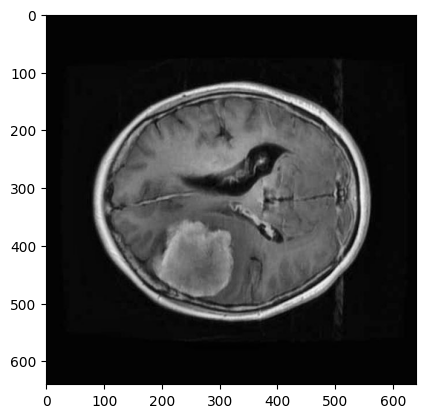

In [11]:
sample_train_img = cv2.imread(f"{train_dir}/{img_name}")
plt.imshow(sample_train_img)

In [12]:
train_annot["annotations"][idx]

{'id': 1003,
 'image_id': 1003,
 'category_id': 2,
 'bbox': [189, 340, 142.5, 162.5],
 'area': 23156.25,
 'segmentation': [[331.25,
   340,
   188.75,
   340,
   188.75,
   502.5,
   331.25,
   502.5,
   331.25,
   340]],
 'iscrowd': 0}

In [13]:
bbox = train_annot["annotations"][idx]["bbox"]
bbox = np.array(bbox, dtype=np.int32)
x, y, w, h =  bbox

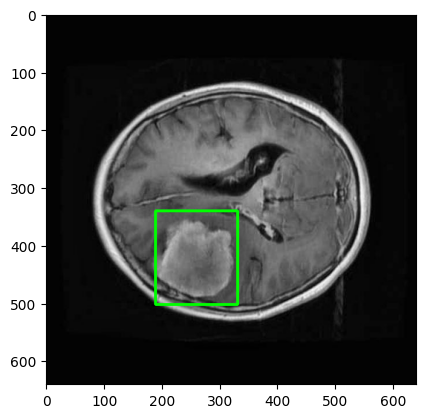

In [14]:
cv2.rectangle(sample_train_img, (x, y), (x+w, y+h), (0,255,0), 3)
plt.imshow(sample_train_img)

In [15]:
num_images = 9

indices = np.random.randint(0, len(train_annot["images"]), size = num_images)
indices

array([1125,  371,  805,  658,  750, 1246, 1261,  823, 1352])

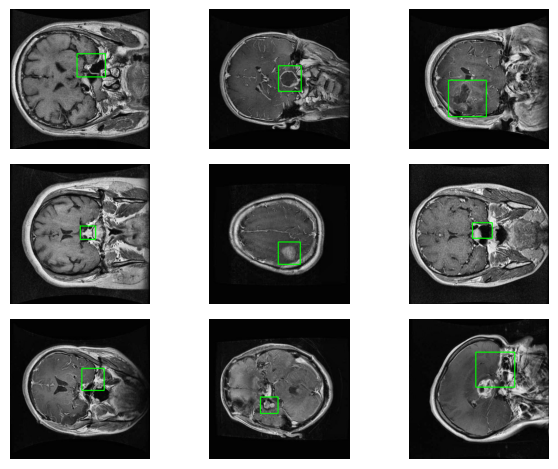

In [16]:
for i, idx in enumerate(indices):

    # Read image filename
    img_name = train_annot["images"][idx]["file_name"]

    # Load image
    sample_train_img = cv2.imread(f"{train_dir}/{img_name}")

    # Get Bounding box coordinates
    bbox = train_annot["annotations"][idx]["bbox"]
    bbox = np.array(bbox, dtype=np.int32)
    x, y, w, h =  bbox

    # Draw bounding box
    cv2.rectangle(sample_train_img, (x, y), (x+w, y+h), (0,255,0), 3)

    # Display image
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(sample_train_img)



# Create ground truths for training

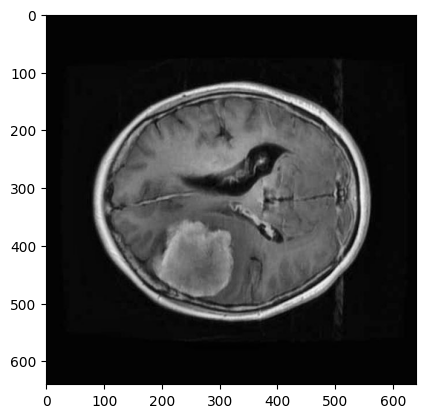

In [17]:
train_dir = "dataset/train"

train_annot = json.load(open(glob.glob(f"{train_dir}/*.json")[0]))

idx = 1003
img_name = train_annot["images"][idx]["file_name"]

sample_train_img = cv2.imread(f"{train_dir}/{img_name}")
plt.imshow(sample_train_img)

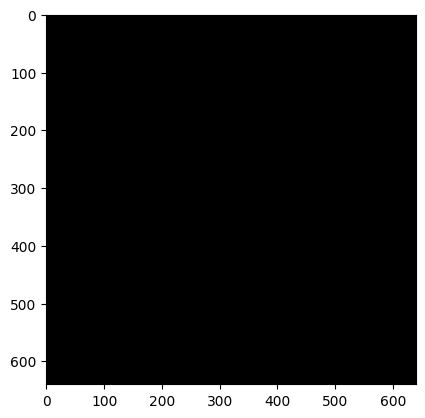

In [18]:
mask = np.zeros((sample_train_img.shape[0], sample_train_img.shape[1]), dtype=np.uint8)
plt.imshow(mask, cmap="gray")

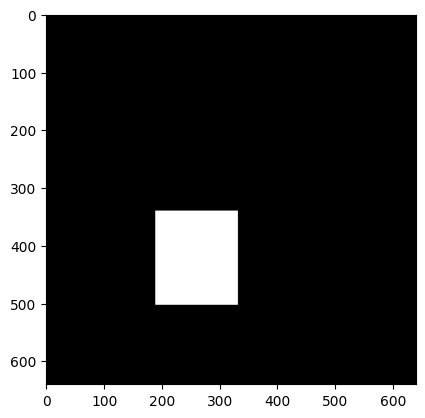

In [19]:
bbox = train_annot["annotations"][idx]["bbox"]
bbox = np.array(bbox, dtype=np.int32)
x, y, w, h =  bbox

cv2.rectangle(mask, (x, y), (x+w, y+h), (255,255,255), -1)
plt.imshow(mask, cmap="gray")

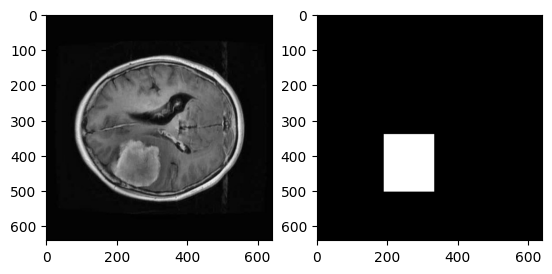

In [20]:
plt.subplot(121)
plt.imshow(sample_train_img)
plt.subplot(122)
plt.imshow(mask, cmap="gray")

In [21]:
#cv2.imwrite("sample_mask.jpg", mask)

In [22]:
train_mask_dir = "dataset/train_mask"

In [23]:
import os

os.path.exists(train_mask_dir)

True

In [24]:
if os.path.exists(train_mask_dir) == False:
    os.mkdir(train_mask_dir)
    print("train_mask directory created. Loading masks....")
    cv2.imwrite(f"{train_mask_dir}/sample_mask.jpg", mask)
    print("Done")
else:
    print("train_mask directory already exists")

train_mask directory already exists


In [25]:
if os.path.exists(train_mask_dir) == False:
    
    os.mkdir(train_mask_dir)
    print("train_mask directory created. Loading masks....")

    for idx in range(3):
    
        img_name = train_annot["images"][idx]["file_name"]
        sample_train_img = cv2.imread(f"{train_dir}/{img_name}")

        mask = np.zeros((sample_train_img.shape[0], sample_train_img.shape[1]), dtype=np.uint8)

        bbox = train_annot["annotations"][idx]["bbox"]
        bbox = np.array(bbox, dtype=np.int32)
        x, y, w, h =  bbox
        cv2.rectangle(mask, (x, y), (x+w, y+h), (255,255,255), -1)

        cv2.imwrite(f"{train_mask_dir}/mask_{img_name}", mask)

    print("Done")

else:
    print("train_mask directory already exists")

train_mask directory already exists


# Pre-process images before training

In [26]:
target_size = (128, 128)

X_train =  [cv2.resize(cv2.imread(train_dir + "/" + image['file_name']),target_size) for image in train_annot['images']]
y_train = [cv2.resize(cv2.imread(train_mask_dir + "/mask_" +image['file_name'],cv2.IMREAD_GRAYSCALE),target_size ) for image in train_annot['images']]

In [27]:
X_train = np.array(X_train)
y_train = np.expand_dims(np.array(y_train), axis=-1)

In [28]:
np.unique(y_train)

array([  0,   1,   2,   3,   4,   5,   7, 249, 250, 251, 252, 253, 254,
       255], dtype=uint8)

In [29]:
X_train = X_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0

In [30]:
np.unique(y_train)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02745098, 0.9764706 , 0.98039216, 0.9843137 ,
       0.9882353 , 0.99215686, 0.99607843, 1.        ], dtype=float32)

In [31]:
y_train = (y_train > 0.5).astype(np.float32)

In [32]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [33]:
X_train.shape

(1502, 128, 128, 3)

In [34]:
y_train.shape

(1502, 128, 128, 1)

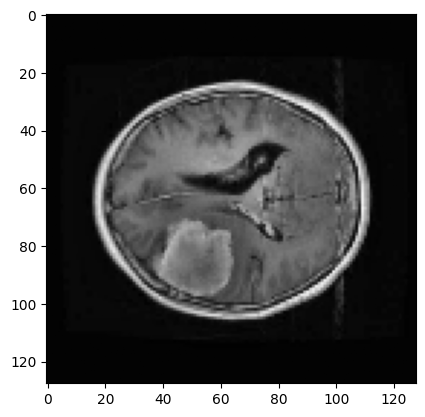

In [35]:
plt.imshow(X_train[idx])

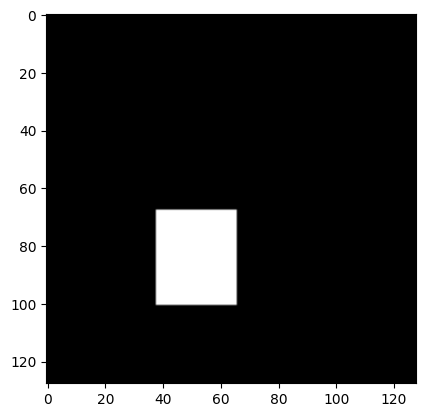

In [36]:
plt.imshow(y_train[idx], cmap="gray")

# Testing `preprocess.py`

In [37]:
from preprocess import load_data

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()

Loading preprocessed dataset ....
Done


In [38]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1502, 128, 128, 3)
(1502, 128, 128, 1)
(429, 128, 128, 3)
(429, 128, 128, 1)
(215, 128, 128, 3)
(215, 128, 128, 1)


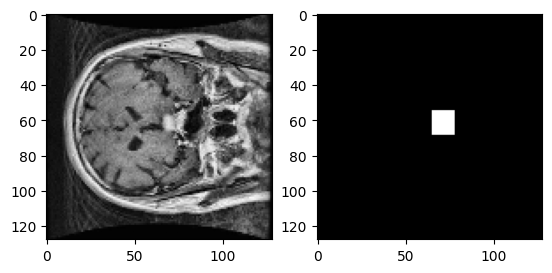

In [39]:
idx=128

plt.subplot(121)
plt.imshow(X_train[idx])
plt.subplot(122)
plt.imshow(Y_train[idx], cmap="gray")

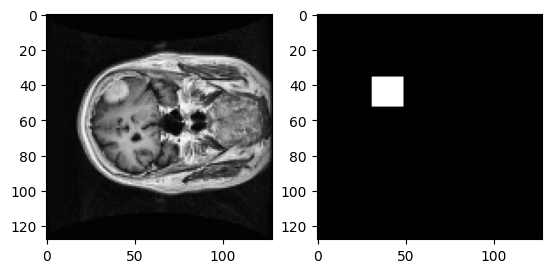

In [40]:
idx = 200

plt.subplot(121)
plt.imshow(X_val[idx])
plt.subplot(122)
plt.imshow(Y_val[idx], cmap="gray")

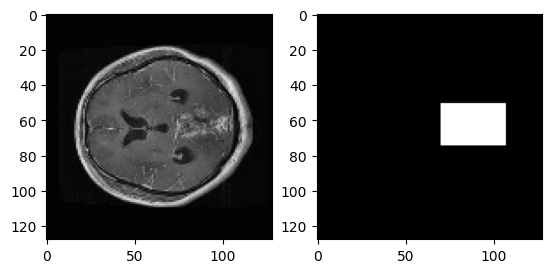

In [41]:
idx = 80

plt.subplot(121)
plt.imshow(X_test[idx])
plt.subplot(122)
plt.imshow(Y_test[idx], cmap="gray")

# U-Net model Architecture

In [94]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import load_model, Model

In [44]:
def double_conv(input, filters):

    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same")(input)
    bn1 = BatchNormalization()(conv1)
    af1 = ReLU()(bn1)

    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same")(af1)
    bn2 = BatchNormalization()(conv2)
    af2 = ReLU()(bn2)

    return af2

In [46]:
def encoder(input, filters):
    enc = double_conv(input, filters)
    pool = MaxPooling2D(strides=(2,2))(enc)
    return enc, pool

In [47]:
def decoder(input, features, filters):
    upsamp = Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2), padding="same")(input)
    concat = Concatenate()([upsamp, features])
    out = double_conv(concat, filters)
    return out

In [48]:
def U_Net(image_shape):

    input = Input(image_shape)

    enc1, pool1 = encoder(input, 64)
    enc2, pool2 = encoder(pool1, 128)
    enc3, pool3 = encoder(pool2, 256)
    enc4, pool4 = encoder(pool3, 512)

    bottleneck = double_conv(pool4, 1024)

    dec1 = decoder(bottleneck, enc4, 512)
    dec2 = decoder(dec1, enc3, 256)
    dec3 = decoder(dec2, enc2, 128)
    dec4 = decoder(dec3, enc1, 64)

    output = Conv2D(1, 1, padding="same", activation="sigmoid")(dec4)

    model = Model(input, output)

    return model

In [49]:
image_shape = (128, 128, 3)

model = U_Net(image_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [50]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)
callbacks_list = [earlystop]

In [52]:
model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=["accuracy"])

In [ ]:
model.fit(X_train,Y_train,epochs=50,validation_data=(X_val,Y_val),callbacks=callbacks_list)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - accuracy: 0.9657 - loss: 0.1221 - val_accuracy: 0.1304 - val_loss: 9.3059
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 349s 7s/step - accuracy: 0.9665 - loss: 0.1043 - val_accuracy: 0.6526 - val_loss: 0.5052
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 358s 8s/step - accuracy: 0.9679 - loss: 0.0961 - val_accuracy: 0.7934 - val_loss: 0.3853
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 353s 8s/step - accuracy: 0.9675 - loss: 0.0907 - val_accuracy: 0.8159 - val_loss: 0.3602
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - accuracy: 0.9690 - loss: 0.0855 - val_accuracy: 0.9363 - val_loss: 0.1705
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - accuracy: 0.9707 - loss: 0.0804 - val_accuracy: 0.9570 - val_loss: 0.1339
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 335s 7s/step - accuracy: 0.9696 - loss: 0.0818 - val_accuracy: 0.9125 - val_loss: 0.2010
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 336s 7s/step - accuracy: 0.9708 - loss: 0.0788 - val_accuracy: 0.9183 - v

In [ ]:
#model.save("U_Net.keras")

# Testing saved model

In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
from preprocess import load_data

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()

saved = load_model("U_Net.keras")

Loading preprocessed dataset ....
Done


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


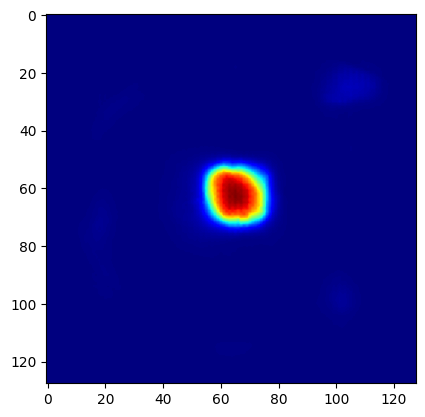

In [2]:
idx = 73

pred_mask = saved.predict(X_test[[idx]])[0]
plt.imshow(pred_mask, cmap="jet")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


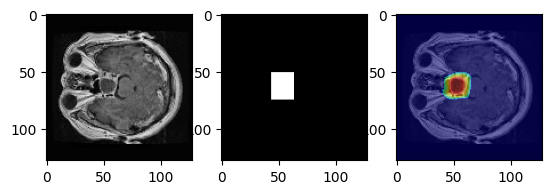

In [3]:
idx = 207

plt.subplot(131)
plt.imshow(X_test[idx])
plt.subplot(132)
plt.imshow(Y_test[idx], cmap= "gray")
plt.subplot(133)
plt.imshow(X_test[idx])
pred_mask = saved.predict(X_test[[idx]])[0]
pred_mask[pred_mask < 0.3] = 0
plt.imshow(pred_mask, cmap="jet", alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


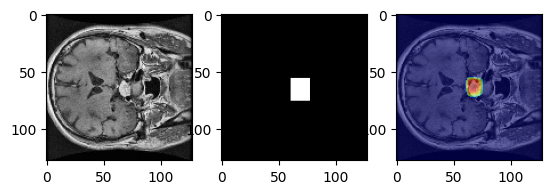

In [4]:
idx = 104

plt.subplot(131)
plt.imshow(X_test[idx])
plt.subplot(132)
plt.imshow(Y_test[idx], cmap= "gray")
plt.subplot(133)
plt.imshow(X_test[idx])
pred_mask = saved.predict(X_test[[idx]])[0]
pred_mask[pred_mask < 0.3] = 0
plt.imshow(pred_mask, cmap="jet", alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


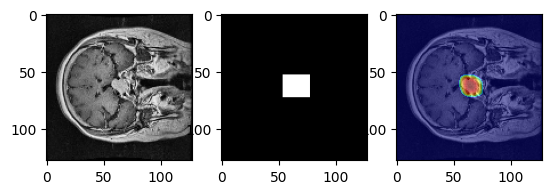

In [5]:
idx = 73

plt.subplot(131)
plt.imshow(X_test[idx])
plt.subplot(132)
plt.imshow(Y_test[idx], cmap= "gray")
plt.subplot(133)
plt.imshow(X_test[idx])
pred_mask = saved.predict(X_test[[idx]])[0]
pred_mask[pred_mask < 0.3] = 0
plt.imshow(pred_mask, cmap="jet", alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


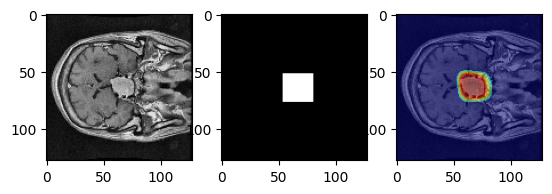

In [6]:
idx = 156

plt.subplot(131)
plt.imshow(X_train[idx])
plt.subplot(132)
plt.imshow(Y_train[idx], cmap= "gray")
plt.subplot(133)
plt.imshow(X_train[idx])
pred_mask = saved.predict(X_train[[idx]])[0]
pred_mask[pred_mask < 0.3] = 0
plt.imshow(pred_mask, cmap="jet", alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


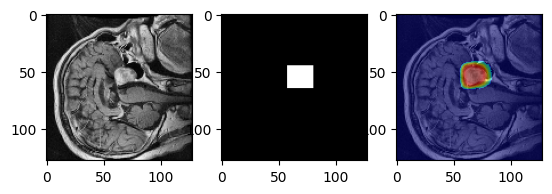

In [7]:
idx = 220

plt.subplot(131)
plt.imshow(X_val[idx])
plt.subplot(132)
plt.imshow(Y_val[idx], cmap= "gray")
plt.subplot(133)
plt.imshow(X_val[idx])
pred_mask = saved.predict(X_val[[idx]])[0]
pred_mask[pred_mask < 0.3] = 0
plt.imshow(pred_mask, cmap="jet", alpha=0.5)

# Evaluation

In [ ]:
train_loss, train_acc = saved.evaluate(X_train, Y_train)
valid_loss, valid_acc = saved.evaluate(X_val, Y_val)
test_loss, test_acc = saved.evaluate(X_test, Y_test)

print(f"Train Loss: {train_loss}   Train Accuracy: {train_acc}")
print(f"Valid Loss: {valid_loss}   Valid Accuracy: {valid_acc}")
print(f"Test Loss: {test_loss}     Test Accuracy: {test_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9861 - loss: 0.0367
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9743 - loss: 0.0696
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9737 - loss: 0.0743
Train Loss: 0.041359029710292816   Train Accuracy: 0.9840697646141052
Valid Loss: 0.071473628282547   Valid Accuracy: 0.9741528034210205
Test Loss: 0.06864826381206512     Test Accuracy: 0.9746885895729065
